In [1]:
from PIL import Image
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
try:
    import google.colab, sys
    !git clone https://github.com/mualal/computer-vision-with-python.git
    sys.path.append('computer-vision-with-python')
    %cd computer-vision-with-python
except:
    import sys
    sys.path.append('..')

In [3]:
import homography
import warp

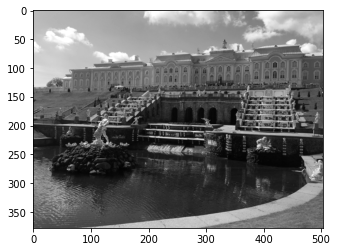

In [4]:
im = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
plt.gray()
plt.imshow(im)

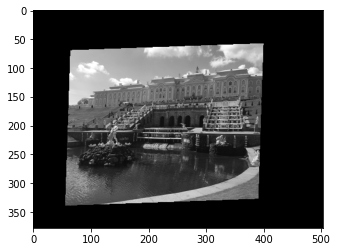

In [5]:
h = np.array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0, 0, 1]])
im2 = ndimage.affine_transform(im, h[:2, :2], (h[0, 2], h[1, 2]))
plt.imshow(im2)

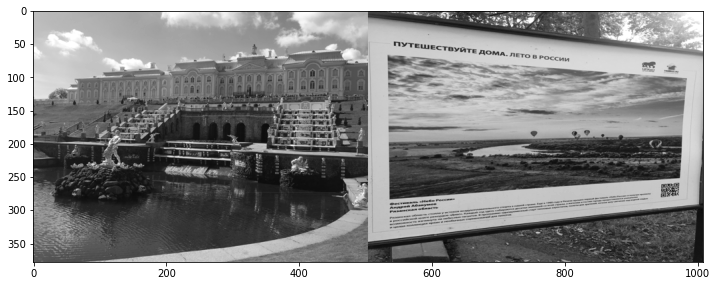

In [6]:
im1 = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
im2 = np.fliplr(np.array(Image.open(os.path.join('images_input', 'Sky.jpg')).resize((378, 504)).convert('L')).T)
plt.figure(figsize=(12,12))
plt.imshow(np.concatenate((im1, im2), axis=1))

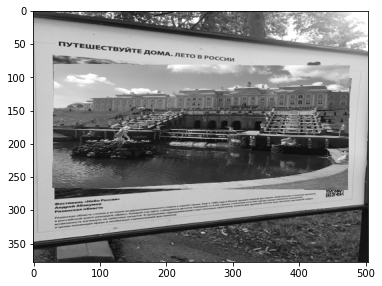

In [7]:
# %matplotlib widget

tp = np.array([[65, 282.8, 253, 99.6], [27.5, 32, 470.6, 480.7], [1, 1, 1, 1]])
im3 = warp.image_to_image(im1, im2, tp)
plt.figure(figsize=(6,6))
plt.imshow(im3)

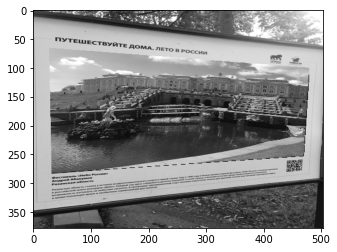

In [8]:
m, n = im1.shape[:2]
fp = np.array([[0, m, m, 0], [0, 0, n, n], [1, 1, 1, 1]])

tp2 = tp[:, :3]
fp2 = fp[:, :3]
h = homography.haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, h[:2, :2], (h[0, 2], h[1, 2]), im2.shape[:2])
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1 - alpha) * im2 + alpha * im1_t

tp2 = tp[:, [0, 2, 3]]
fp2 = fp[:, [0, 2, 3]]
h = homography.haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, h[:2, :2], (h[0, 2], h[1, 2]), im2.shape[:2])
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im4 = (1 - alpha) * im3 + alpha * im1_t

plt.figure()
plt.imshow(im4)
plt.show()

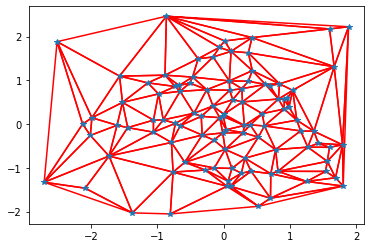

In [9]:
x, y = np.array(np.random.standard_normal((2, 100)))
tri = Delaunay(np.c_[x, y]).simplices

plt.figure()
for t in tri:
    t_ext = [t[0], t[1], t[2], t[0]]
    plt.plot(x[t_ext], y[t_ext], 'r')
plt.plot(x, y, '*')
plt.show()

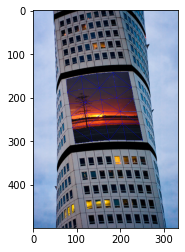

In [10]:
fromim = np.array(Image.open(os.path.join('images_input', 'sunset_tree.jpg')))
x, y = np.meshgrid(range(5), range(6))

x = (fromim.shape[1] / 4) * x.flatten()
y = (fromim.shape[0] / 5) * y.flatten()

tri = warp.triangulate_points(x, y)

im = np.array(Image.open(os.path.join('images_input', 'turningtorso1.jpg')))
tp = np.loadtxt(os.path.join('images_input', 'turningtorso1_points.txt'))

fp = np.vstack((y, x, np.ones((1, len(x)))))
tp = np.vstack((tp[:, 1], tp[:, 0], np.ones((1, len(tp)))))

im = warp.pw_affine(
    from_im=fromim,
    to_im=im,
    from_points=fp,
    to_points=tp,
    tri=tri
)

plt.figure()
plt.imshow(im)
warp.plot_mesh(tp[1], tp[0], tri)
plt.show()